# Inferential Statistics

Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import branca
import json
import seaborn as sns
from scipy import stats

Read Data

In [2]:
# read establishment data
biz = pd.read_csv("data/interim/establishments.csv", encoding="latin-1")

# read immigration data
exemptions_in = pd.read_csv("data/interim/exemptions_inflow.csv", encoding="latin-1")

# compute summary statistics
exemptions_in["sum"] = exemptions_in.drop(["year", "geo_id"], axis=1).sum(axis=1)
exemptions_in["home"] = exemptions_in.drop(["year","sum", "geo_id"], axis=1).max(axis=1)
exemptions_in["immigrants"] = exemptions_in["sum"] - exemptions_in["home"]

# read emigration data
exemptions_out = pd.read_csv("data/interim/exemptions_outflow.csv", encoding="latin-1")

# compute summary statistics
exemptions_out["sum"] = exemptions_out.drop("year", axis=1).drop("geo_id", axis=1).sum(axis=1)
exemptions_out["home"] = exemptions_out.drop(["year","sum", "geo_id"], axis=1).max(axis=1)
exemptions_out["emigrants"] = exemptions_out["sum"] - exemptions_out["home"]


Merge business and population data

In [3]:
# select and normalize retail column from 0 to 1
biz = biz[["geo_id", "year", "Retail trade"]]
#biz["Retail trade"] = (biz["Retail trade"] - biz["Retail trade"].min() ) / (biz["Retail trade"].max() - biz["Retail trade"].min())

# select and normalize population total column from 0 to 1
exemptions_in = exemptions_in[["geo_id", "year", "sum", "home", "immigrants"]]
#exemptions_in["sum"] = (exemptions_in["sum"] - exemptions_in["sum"].min()) / (exemptions_in["sum"].max() - exemptions_in["sum"].min())

# merge business and population dataframes
biz_pop = pd.merge(biz[["geo_id", "year", "Retail trade"]],
                       exemptions_in[["geo_id", "year", "sum", "home", "immigrants"]],
                       how="left",
                       on=["geo_id", "year"],
                       suffixes=("_biz","_pop")).fillna(0)

## Glance at the distributions of county sizes by retail trade and population

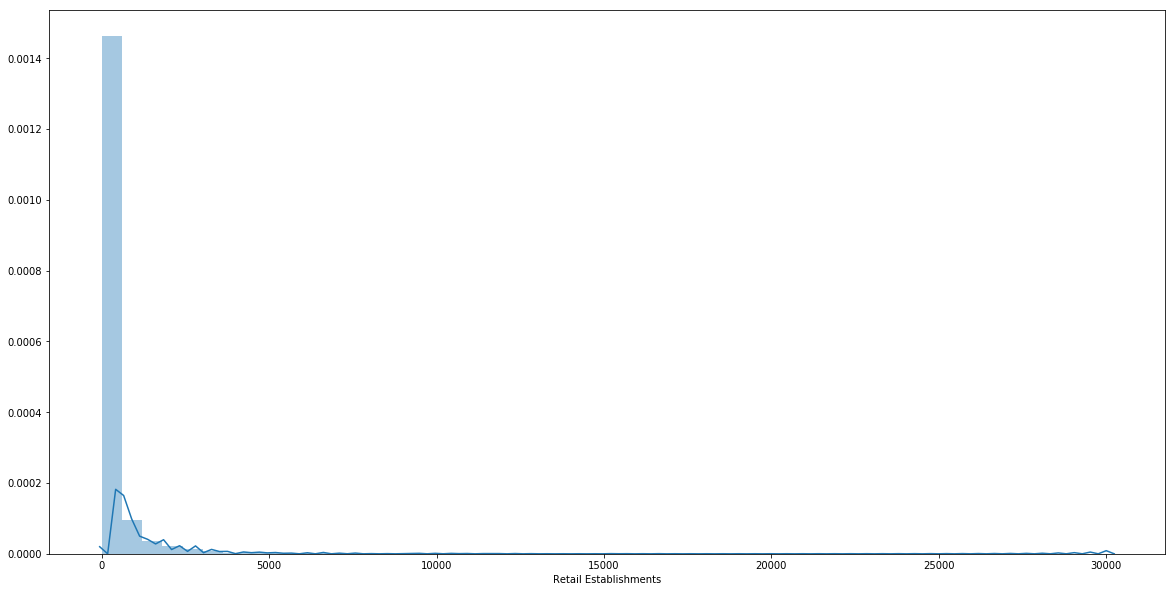

In [4]:
plt.figure(figsize=(20,10))

sns.distplot(biz_pop["Retail trade"])
plt.xlabel("Retail Establishments")
plt.savefig("retail-distribution.png")
plt.show()

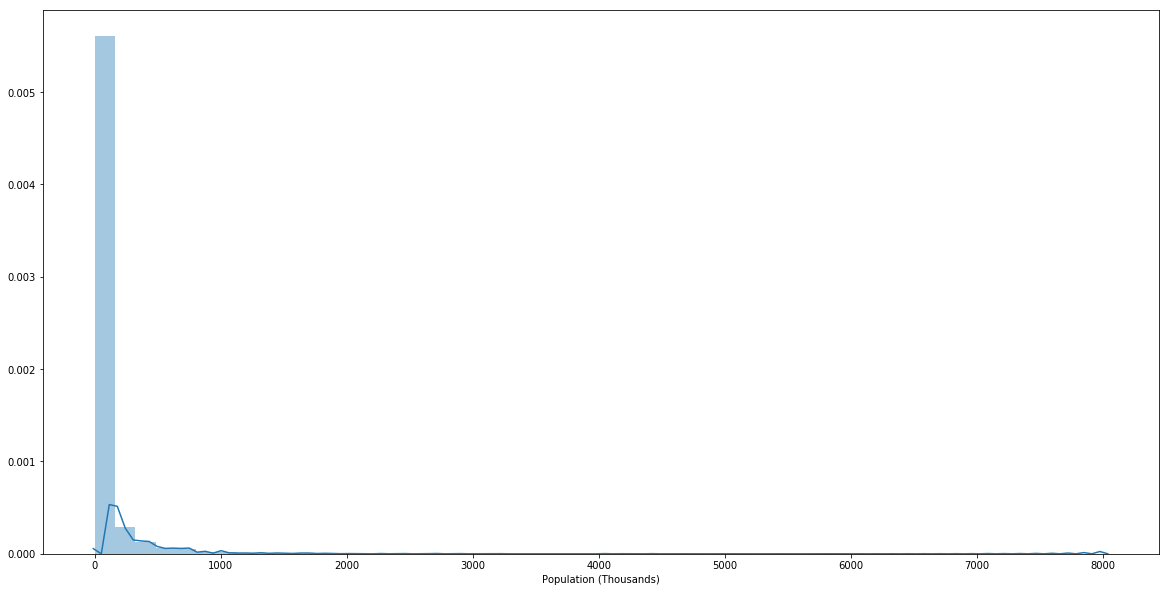

In [5]:
plt.figure(figsize=(20,10))

sns.distplot(biz_pop["sum"] / 1000)
plt.xlabel("Population (Thousands)")
plt.xticks()
plt.savefig("population-distribution.png")

plt.show()

## Confirming that Retail Trade correlates with Population

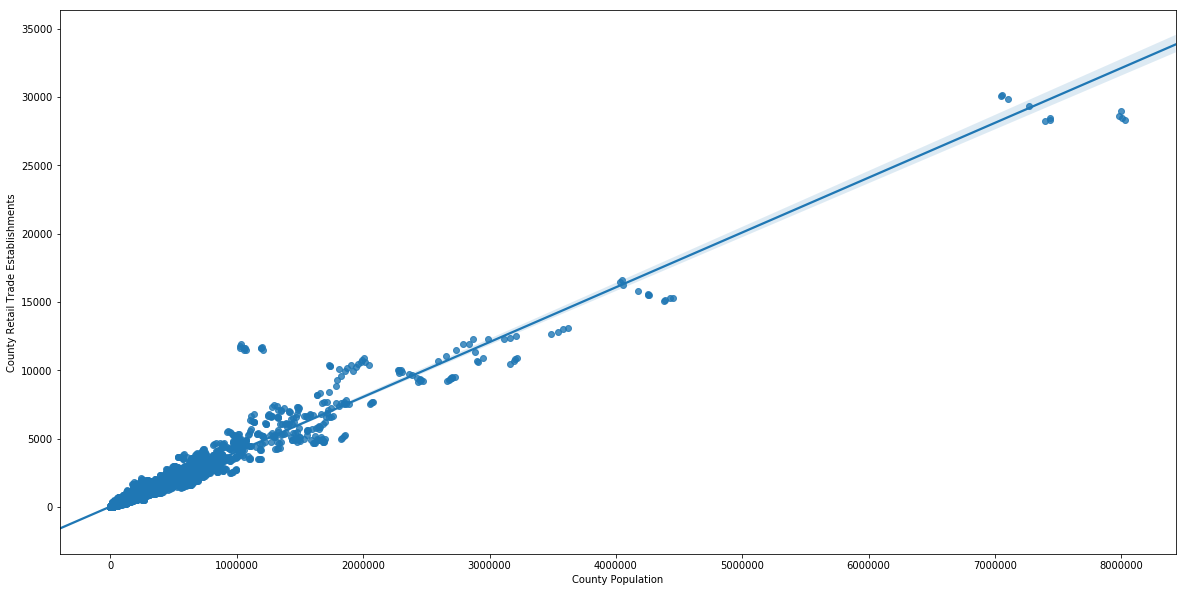

In [6]:
plt.figure(figsize=(20,10))

sns.regplot(x="sum", y="Retail trade", data=biz_pop)

plt.ylabel("County Retail Trade Establishments")
plt.xlabel("County Population")
plt.savefig("population-retail.png")

plt.show()

## Comparing retail trade growth to population growth

Mergine dataframe with itself to look at each year's subsequent year's values

In [7]:
# set create a year column for previous year
biz_pop["previous_year"] = biz_pop["year"]-1

# merge year 2 data with year 1 data by matching year to "previous year" of next year
biz_pop = pd.merge(biz_pop,
                       biz_pop,
                       how="left",
                       left_on=["geo_id", "year"],
                       right_on=["geo_id", "previous_year"],
                       suffixes=("_y1","_y2")).fillna(0)

# drop extra columns
biz_pop = biz_pop.drop(["previous_year_y1", "previous_year_y2"], 1)

# convert floats to int
biz_pop = biz_pop.astype(int)

Calculating new columns

In [8]:
# calculate change in retail establishments
biz_pop["retail_growth"] = biz_pop["Retail trade_y2"] - biz_pop["Retail trade_y1"]

# calculate change in population
biz_pop["population_growth"] = biz_pop["sum_y2"] - biz_pop["sum_y1"]

# drop 2005 from table
biz_pop = biz_pop[biz_pop["year_y2"] != 0]

Standardize values of interest (standard score)

In [9]:
biz_pop["retail_growth"] = (biz_pop["retail_growth"] - biz_pop["retail_growth"].mean()) / np.var((biz_pop["retail_growth"]))

biz_pop["population_growth"] = (biz_pop["population_growth"] - biz_pop["population_growth"].mean()) / np.var((biz_pop["population_growth"]))


In [10]:
biz_pop.head()

,geo_id,year_y1,Retail trade_y1,sum_y1,home_y1,immigrants_y1,year_y2,Retail trade_y2,sum_y2,home_y2,immigrants_y2,retail_growth,population_growth
0,1001,2005,176,42270,35901,6369,2006,180,43578,36850,6728,0.015307,7.570496e-06
1,1001,2006,180,43578,36850,6728,2007,176,44329,37767,6562,-0.006207,-2.506018e-06
2,1001,2007,176,44329,37767,6562,2008,176,45929,39518,6411,0.004550,1.285298e-05
3,1001,2008,176,45929,39518,6411,2009,175,46822,40719,6103,0.001861,6.285968e-08
4,1001,2009,175,46822,40719,6103,2010,173,45868,40099,5769,-0.000829,-3.335064e-05


### All Years

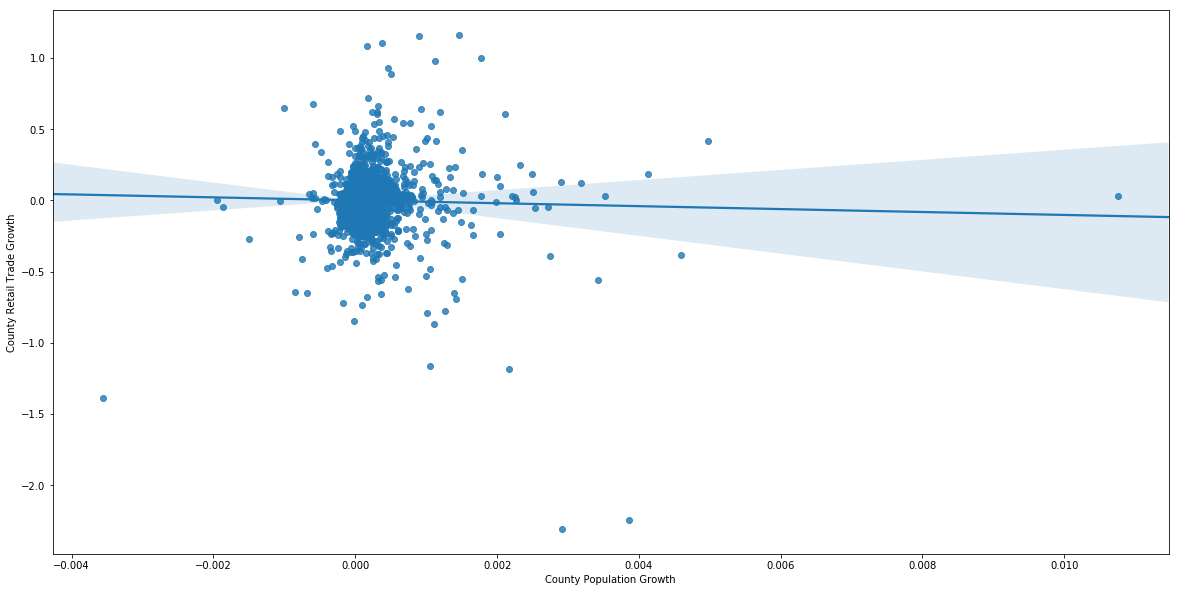

(-0.026675962358629519, 2.2546051663033393e-06)


In [11]:
plt.figure(figsize=(20,10))

sns.regplot(x="population_growth", y="retail_growth", data=biz_pop)

plt.ylabel("County Retail Trade Growth")
plt.xlabel("County Population Growth")
plt.show()
plt.savefig("popgrowth-retailgrowth.png")

print(stats.pearsonr(biz_pop["population_growth"], biz_pop["retail_growth"]))

### 2006 and 2007

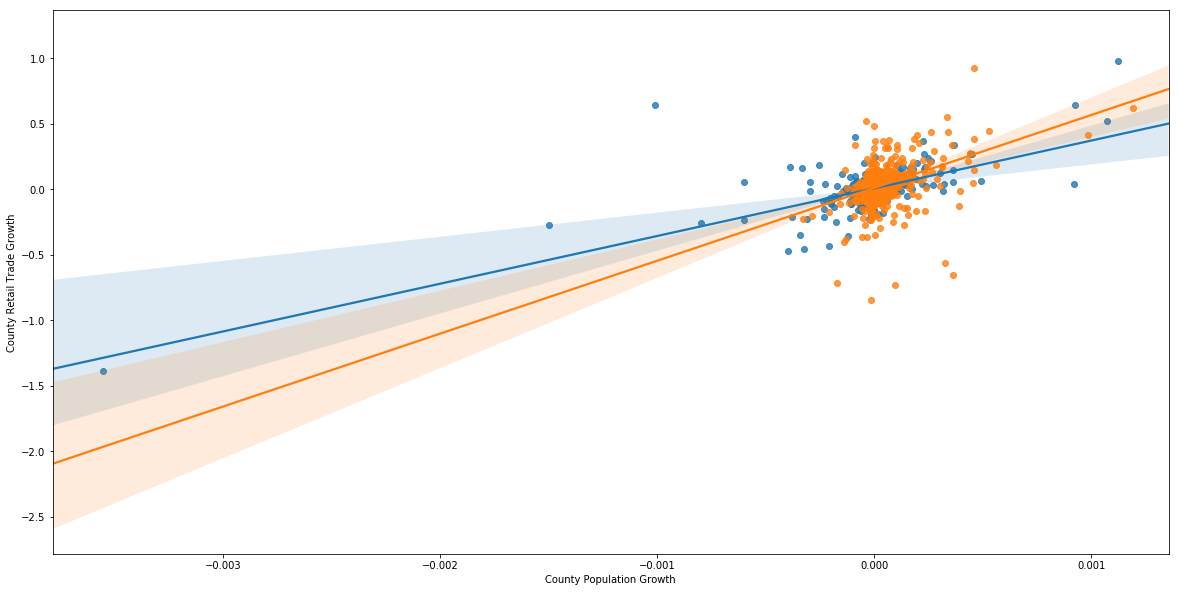

(0.64253457685744819, 0.0)
(0.48765483156266204, 2.0260817931999386e-187)


In [12]:
plt.figure(figsize=(20,10))

sns.regplot(x="population_growth", y="retail_growth", data=biz_pop[biz_pop["year_y2"] == 2006])
sns.regplot(x="population_growth", y="retail_growth", data=biz_pop[biz_pop["year_y2"] == 2007])

plt.ylabel("County Retail Trade Growth")
plt.xlabel("County Population Growth")
plt.savefig("popgrowth-retailgrowth0607.png")

plt.show()
print(stats.pearsonr(biz_pop[biz_pop["year_y2"] == 2006]["population_growth"], biz_pop[biz_pop["year_y2"] == 2006]["retail_growth"]))
print(stats.pearsonr(biz_pop[biz_pop["year_y2"] == 2007]["population_growth"], biz_pop[biz_pop["year_y2"] == 2007]["retail_growth"]))


### 2008 and 2009

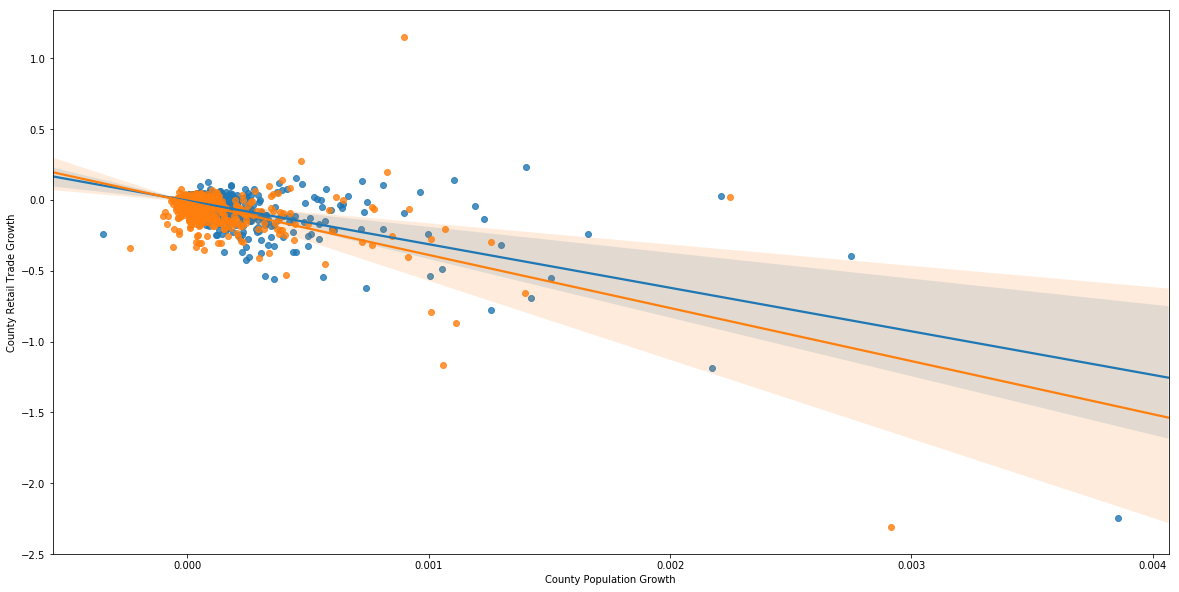

(-0.67478708511604957, 0.0)
(-0.58591937665550375, 4.4666341926069959e-289)


In [13]:
plt.figure(figsize=(20,10))


sns.regplot(x="population_growth", y="retail_growth", data=biz_pop[biz_pop["year_y2"] == 2008])
sns.regplot(x="population_growth", y="retail_growth", data=biz_pop[biz_pop["year_y2"] == 2009])

plt.legend(loc="center")


plt.ylabel("County Retail Trade Growth")
plt.xlabel("County Population Growth")
plt.savefig("popgrowth-retailgrowth0809.png")

plt.show()
print(stats.pearsonr(biz_pop[biz_pop["year_y2"] == 2008]["population_growth"], biz_pop[biz_pop["year_y2"] == 2008]["retail_growth"]))
print(stats.pearsonr(biz_pop[biz_pop["year_y2"] == 2009]["population_growth"], biz_pop[biz_pop["year_y2"] == 2009]["retail_growth"]))


### 2010 and 2011

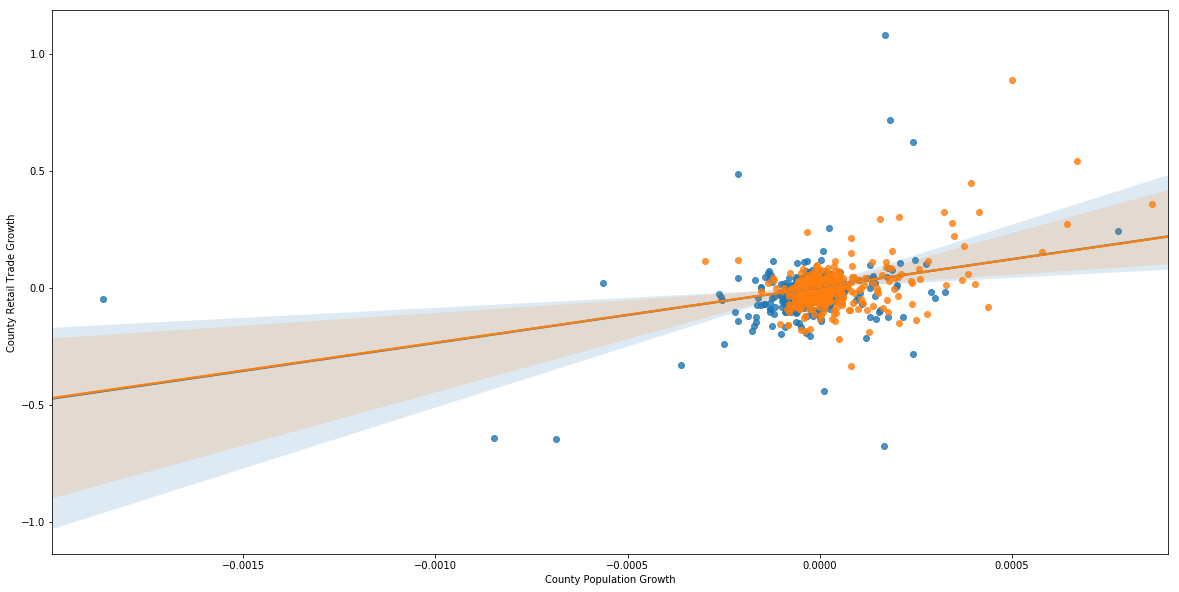

(0.28558807803277542, 4.847182690216979e-60)
(0.37556039472748387, 8.1467766048674919e-106)


In [14]:
plt.figure(figsize=(20,10))

sns.regplot(x="population_growth", y="retail_growth", data=biz_pop[biz_pop["year_y2"] == 2010])
sns.regplot(x="population_growth", y="retail_growth", data=biz_pop[biz_pop["year_y2"] == 2011])

plt.ylabel("County Retail Trade Growth")
plt.xlabel("County Population Growth")
plt.savefig("popgrowth-retailgrowth1011.png")

plt.show()

print(stats.pearsonr(biz_pop[biz_pop["year_y2"] == 2010]["population_growth"], biz_pop[biz_pop["year_y2"] == 2010]["retail_growth"]))
print(stats.pearsonr(biz_pop[biz_pop["year_y2"] == 2011]["population_growth"], biz_pop[biz_pop["year_y2"] == 2011]["retail_growth"]))


### 2012 and 2013

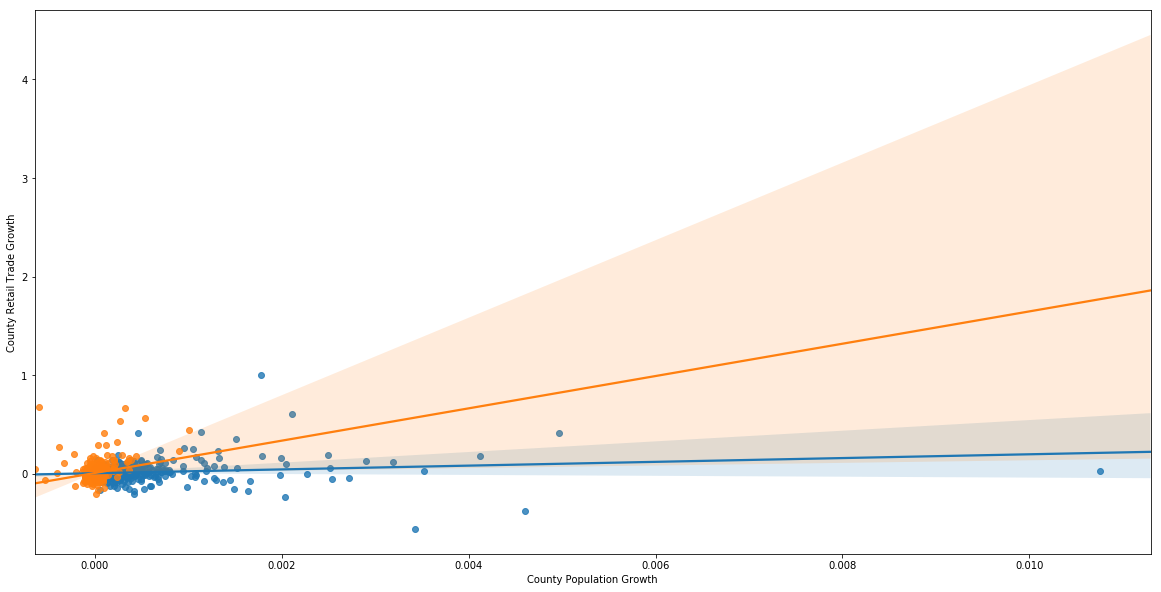

(0.16064442809377463, 1.304427264009457e-19)
(0.26971554039980256, 1.6688835535722828e-53)


In [15]:
plt.figure(figsize=(20,10))

sns.regplot(x="population_growth", y="retail_growth", data=biz_pop[biz_pop["year_y2"] == 2012])
sns.regplot(x="population_growth", y="retail_growth", data=biz_pop[biz_pop["year_y2"] == 2013])



plt.ylabel("County Retail Trade Growth")
plt.xlabel("County Population Growth")
plt.savefig("popgrowth-retailgrowth1213.png")

plt.show()


print(stats.pearsonr(biz_pop[biz_pop["year_y2"] == 2012]["population_growth"], biz_pop[biz_pop["year_y2"] == 2012]["retail_growth"]))
print(stats.pearsonr(biz_pop[biz_pop["year_y2"] == 2013]["population_growth"], biz_pop[biz_pop["year_y2"] == 2013]["retail_growth"]))


## 2014 and 2015

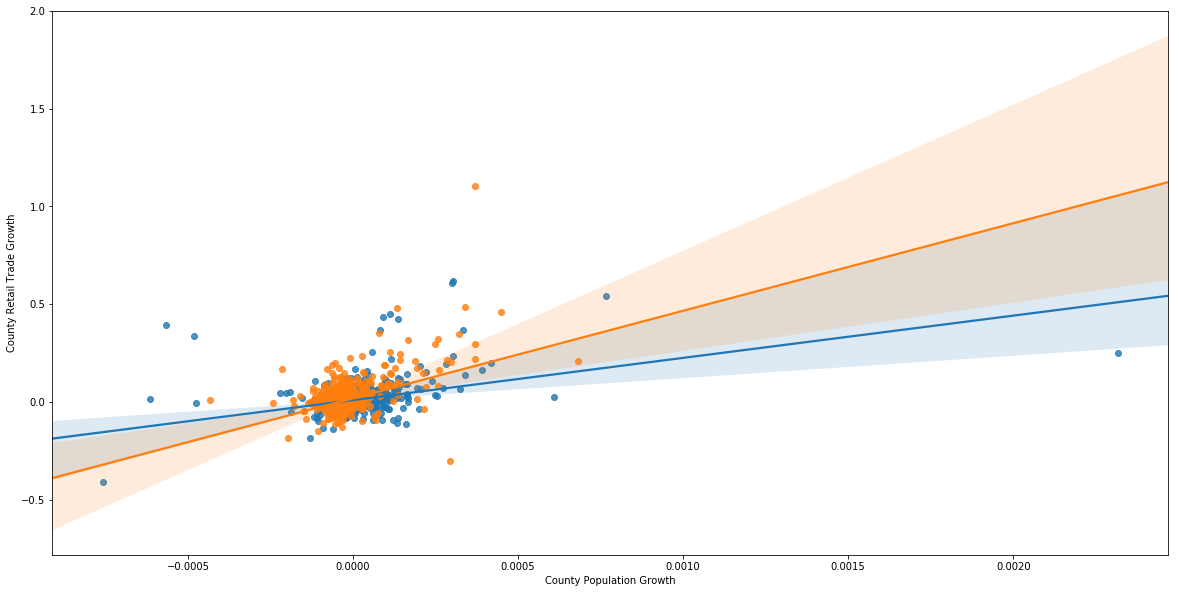

(0.37119339044520039, 3.1608229756794874e-103)
(0.45568651078133066, 6.2211065998104807e-161)


In [16]:
plt.figure(figsize=(20,10))

sns.regplot(x="population_growth", y="retail_growth", data=biz_pop[biz_pop["year_y2"] == 2014])
sns.regplot(x="population_growth", y="retail_growth", data=biz_pop[biz_pop["year_y2"] == 2015])

plt.ylabel("County Retail Trade Growth")
plt.xlabel("County Population Growth")
plt.savefig("popgrowth-retailgrowth1415.png")

plt.show()

print(stats.pearsonr(biz_pop[biz_pop["year_y2"] == 2014]["population_growth"], biz_pop[biz_pop["year_y2"] == 2014]["retail_growth"]))
print(stats.pearsonr(biz_pop[biz_pop["year_y2"] == 2015]["population_growth"], biz_pop[biz_pop["year_y2"] == 2015]["retail_growth"]))


## Interpretation

In [17]:
correlations = []

for year in np.arange(2006,2016):
    correlations.append(stats.pearsonr(biz_pop[biz_pop["year_y2"] == year]["population_growth"], biz_pop[biz_pop["year_y2"] == year]["retail_growth"])[0])

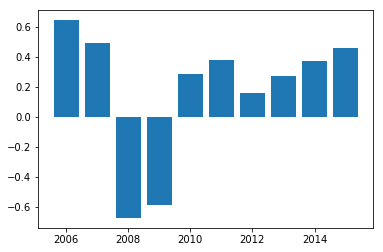

In [18]:
plt.bar(x=np.arange(2006,2016), height=correlations)
plt.savefig("correlation-year.png")

plt.show()

Wow. In some years, the correlation is positive, and in some it's negative. In all years, the Pearson correleation coefficient is calculated with p-values close to 0, meaning the likelihood of measuring these yearly observations given there is truly no correlation is too small to accept that it happened by chance.

In [19]:
pop = pd.merge(exemptions_in[["geo_id", "year", "immigrants"]],
                       exemptions_out[["geo_id", "year", "sum", "emigrants"]],
                       how="left",
                       on=["geo_id", "year"]).fillna(0)

In [20]:
pop.head()

,geo_id,year,immigrants,sum,emigrants
0,1001,2005,6369.0,41122.0,5221.0
1,1001,2006,6728.0,42497.0,5647.0
2,1001,2007,6562.0,43337.0,5570.0
3,1001,2008,6411.0,45166.0,5648.0
4,1001,2009,6103.0,46497.0,5778.0


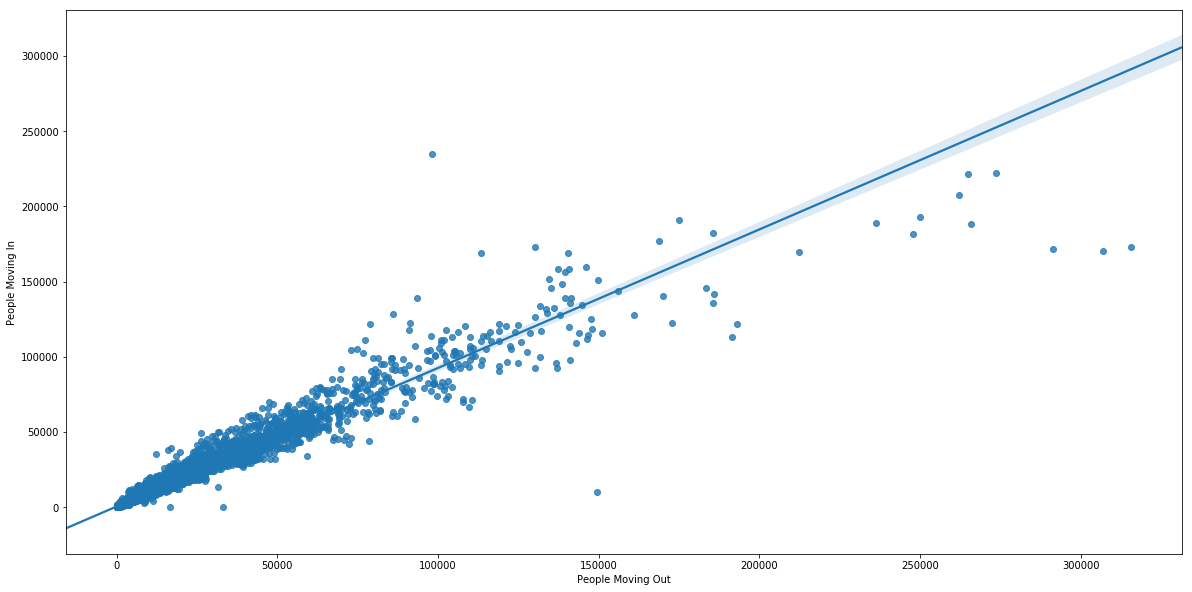

In [21]:
plt.figure(figsize=(20,10))

sns.regplot(x="emigrants", y="immigrants", data=pop)

plt.ylabel("People Moving In")
plt.xlabel("People Moving Out")
plt.savefig("population-retail.png")

plt.show()

In [22]:
migration_correlations = []

for year in np.arange(2006,2016):
    migration_correlations.append(stats.pearsonr(pop[pop["year"] == year]["emigrants"], pop[pop["year"] == year]["immigrants"])[0])

In [23]:
migration_correlations #by year

[0.93544501649296707,
 0.96315559327103417,
 0.98275304869468483,
 0.98787780453198071,
 0.98701179773679648,
 0.99109341340158941,
 0.9909378337079765,
 0.9863250427804805,
 0.97056256738570512,
 0.98594158794329478]

Every year, the correlation between people moving in and out is strong. Though there are some outliers.

In [24]:
linreg = stats.linregress(pop["emigrants"], pop["immigrants"])
pop["linear-immigrants"] = linreg.slope * pop["emigrants"] + linreg.intercept
pop["residual"] = pop["immigrants"] - pop["linear-immigrants"]

In [25]:
pop[np.abs(pop["residual"]) > 50000].sort_values(by="residual").sort_values(by="residual")

,geo_id,year,immigrants,sum,emigrants,linear-immigrants,residual
12622,22071,2006,9759.0,259007.0,149494.0,138111.035272,-128352.035272
2242,6037,2006,173220.0,7192490.0,315742.0,291228.051674,-118008.051674
2243,6037,2007,170234.0,7194806.0,307052.0,283224.425330,-112990.425330
2241,6037,2005,171889.0,7224346.0,291403.0,268811.450800,-96922.450800
6703,17031,2005,113375.0,4129745.0,191455.0,176757.774633,-63382.774633
2244,6037,2008,187943.0,7349837.0,265767.0,245200.292575,-57257.292575
6704,17031,2006,121620.0,4106264.0,193105.0,178277.450521,-56657.450521
2396,6065,2006,138824.0,1451947.0,93540.0,86576.523364,52247.476636
1131,4013,2006,172722.0,2610836.0,130055.0,120207.411278,52514.588722
1130,4013,2005,169297.0,2534588.0,113353.0,104824.607226,64472.392774


In order from least to most, our most abandoned cities are:
    
    Orleans Parish, Louisiana (2006)
    Los Angeles County, California (2006)
    Los Angeles County, California (2007)
    Los Angeles County, California (2005)
    Cook County, Illinois (2005)
    Los Angeles County, California (2008)
    Cook County, Illinois (2006)
    
And our biggest attractions were:
    
    Riverside County, California (2006)
    Maricopa County, Arizona (2006)
    Maricopa County, Arizona (2005)
    Travis County, Texas (2014)

    